In [57]:
import numpy as np
from scipy.stats import norm

# 示例交易链路数据
transactions = [
    {"node_id": 1, "institution": "A", "price": 100, "time": "2024-06-01", "prev_node_id": None},
    {"node_id": 2, "institution": "B", "price": 105, "time": "2024-06-02", "prev_node_id": 1},
    {"node_id": 3, "institution": "A", "price": 130, "time": "2024-06-03", "prev_node_id": 2},
    {"node_id": 4, "institution": "C", "price": 110, "time": "2024-06-04", "prev_node_id": 3},
    # 更多数据...
]

# 数据预处理（简化示例）
prices = [t["price"] for t in transactions]
mean_price = np.mean(prices)
std_price = np.std(prices)

# 异常概率计算（基于高斯模型）
for t in transactions:
    t["anomaly_prob"] = 1 - norm.cdf(t["price"], mean_price, std_price)

# 累计异常概率计算
def cumulative_anomaly_prob(transactions):
    total_prob = 1
    for t in transactions:
        total_prob *= (1 - t["anomaly_prob"])
    return 1 - total_prob

# 检测异常
def detect_anomalies(transactions, price_threshold):
    institution_counts = {}
    anomalies = []
    
    for t in transactions:
        institution = t["institution"]
        if institution not in institution_counts:
            institution_counts[institution] = []
        institution_counts[institution].append(t)
    
    for institution, trans in institution_counts.items():
        if len(trans) > 1:
            prices = [t["price"] for t in trans]
            max_diff = max(prices) - min(prices)
            if max_diff > price_threshold:
                anomalies.append((institution, max_diff))
    
    return anomalies

# 示例检测
cumulative_prob = cumulative_anomaly_prob(transactions)
anomalies = detect_anomalies(transactions, price_threshold=20)

print("累计异常概率:", cumulative_prob)
print("检测到的异常:", anomalies)


累计异常概率: 0.9795713386279064
检测到的异常: [('A', 30)]


当尝试生成所有可能的链路时，我们可以遵循以下步骤：
- 对原始数据进行操作，以获得每个节点作为中心的简单路径。
- 使用这些简单路径，尝试将它们组合起来，以得到任意节点到任意节点的路径。
  - 首先，我们提取每个路径的源节点和目标节点。
  - 然后，对于每个节点对应的路径列表：
    - 检查每条路径，找到路径的最后一个节点作为当前起点。
    - 如果存在以当前起点为起点的路径，并且满足时间递增的条件，则将它们组合成新的路径。
通过这种方法，我们可以生成从任意节点到任意节点的所有可能链路。

In [58]:
import numpy as np
from scipy.stats import norm
import random
from datetime import datetime, timedelta

# 生成模拟数据函数
def generate_synthetic_data(num_chains, max_chain_length):
    institutions = ['A', 'B', 'C', 'D']
    data = []

    for chain_id in range(num_chains):
        chain_length = random.randint(2, max_chain_length)
        prev_node_id = None
        for node_id in range(chain_length):
            institution = random.choice(institutions)
            price = round(random.uniform(90, 150), 2)
            time = datetime(2024, 6, 1) + timedelta(days=node_id)
            data.append({
                "chain_id": chain_id,
                "node_id": node_id,
                "institution": institution,
                "price": price,
                "time": time.strftime("%Y-%m-%d"),
                "prev_node_id": prev_node_id
            })
            prev_node_id = node_id
    return data

# 生成模拟数据
random.seed(42)
synthetic_data = generate_synthetic_data(5, 15)

# 数据预处理
prices = [t["price"] for t in synthetic_data]
mean_price = np.mean(prices)
std_price = np.std(prices)

# 异常概率计算
for t in synthetic_data:
    t["anomaly_prob"] = 1 - norm.cdf(t["price"], mean_price, std_price)

# 累计异常概率计算
def cumulative_anomaly_prob(chain):
    total_prob = 1
    for t in chain:
        total_prob *= (1 - t["anomaly_prob"])
    return 1 - total_prob

# 检测异常
def detect_anomalies(chain, price_threshold):
    institution_counts = {}
    anomalies = []

    for t in chain:
        institution = t["institution"]
        if institution not in institution_counts:
            institution_counts[institution] = []
        institution_counts[institution].append(t)

    for institution, trans in institution_counts.items():
        if len(trans) > 1:
            prices = [t["price"] for t in trans]
            max_diff = max(prices) - min(prices)
            if max_diff > price_threshold:
                anomalies.append((institution, max_diff))

    return anomalies

# 处理每条链路
chain_ids = set(t["chain_id"] for t in synthetic_data)
results = []

for chain_id in chain_ids:
    chain = [t for t in synthetic_data if t["chain_id"] == chain_id]
    cumulative_prob = cumulative_anomaly_prob(chain)
    anomalies = detect_anomalies(chain, price_threshold=20)
    results.append({
        "chain_id": chain_id,
        "cumulative_prob": cumulative_prob,
        "anomalies": anomalies
    })

# 打印结果
for result in results:
    print(f"链路ID: {result['chain_id']}")
    print(f"累计异常概率: {result['cumulative_prob']}")
    print(f"检测到的异常: {result['anomalies']}")
    print()


链路ID: 0
累计异常概率: 0.9999981609728746
检测到的异常: [('A', 44.03), ('C', 33.879999999999995), ('B', 30.230000000000004)]

链路ID: 1
累计异常概率: 0.9947510755883179
检测到的异常: [('C', 30.090000000000003)]

链路ID: 2
累计异常概率: 0.9990394870121878
检测到的异常: [('A', 48.56999999999999), ('C', 24.879999999999995)]

链路ID: 3
累计异常概率: 0.9980221618234766
检测到的异常: [('B', 31.280000000000015), ('A', 22.810000000000002)]

链路ID: 4
累计异常概率: 0.9221861074197452
检测到的异常: []



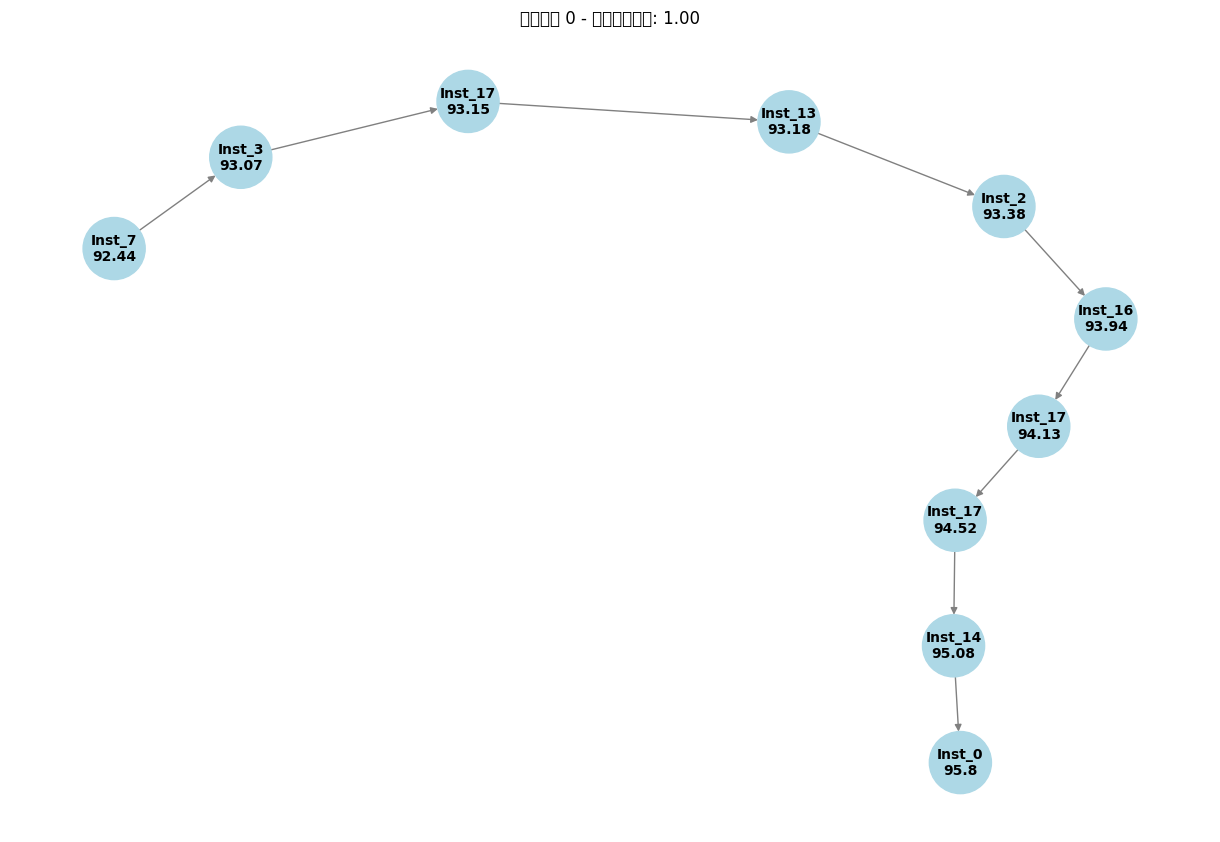

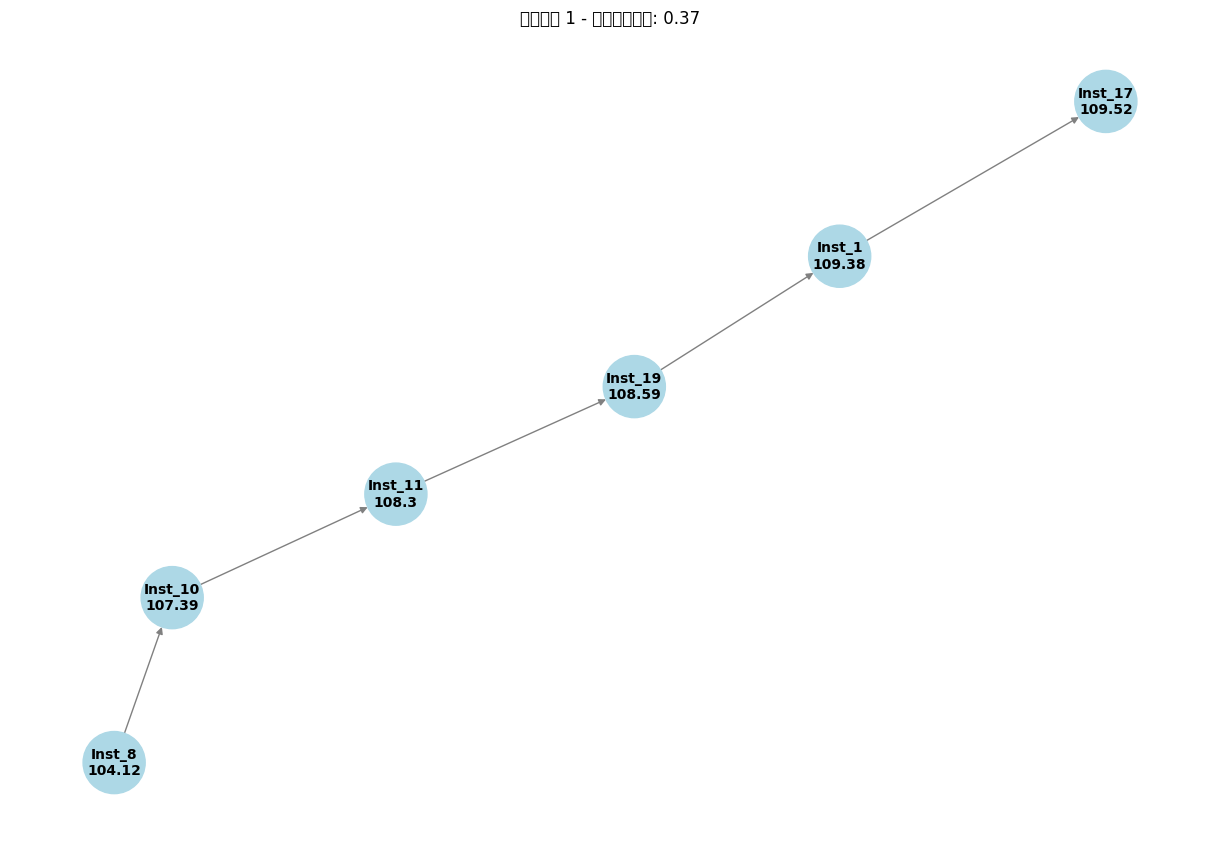

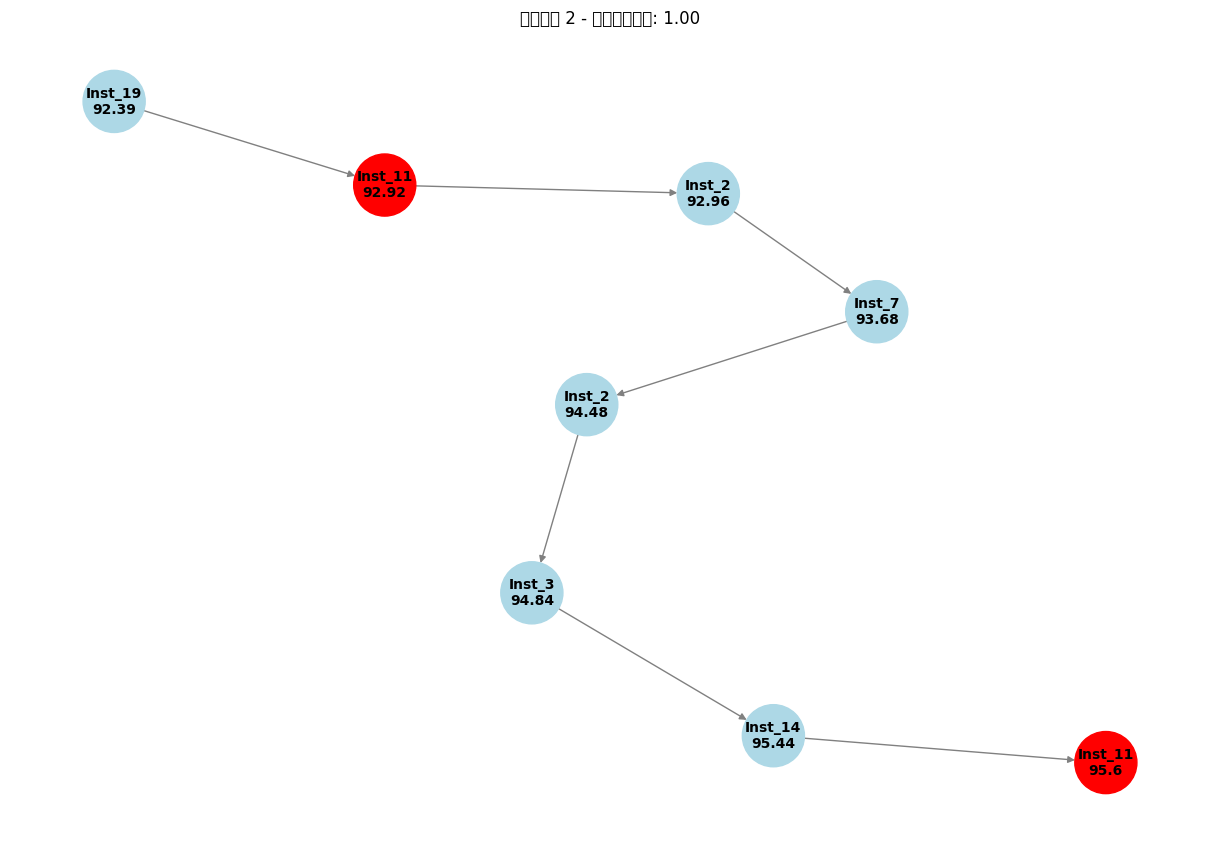

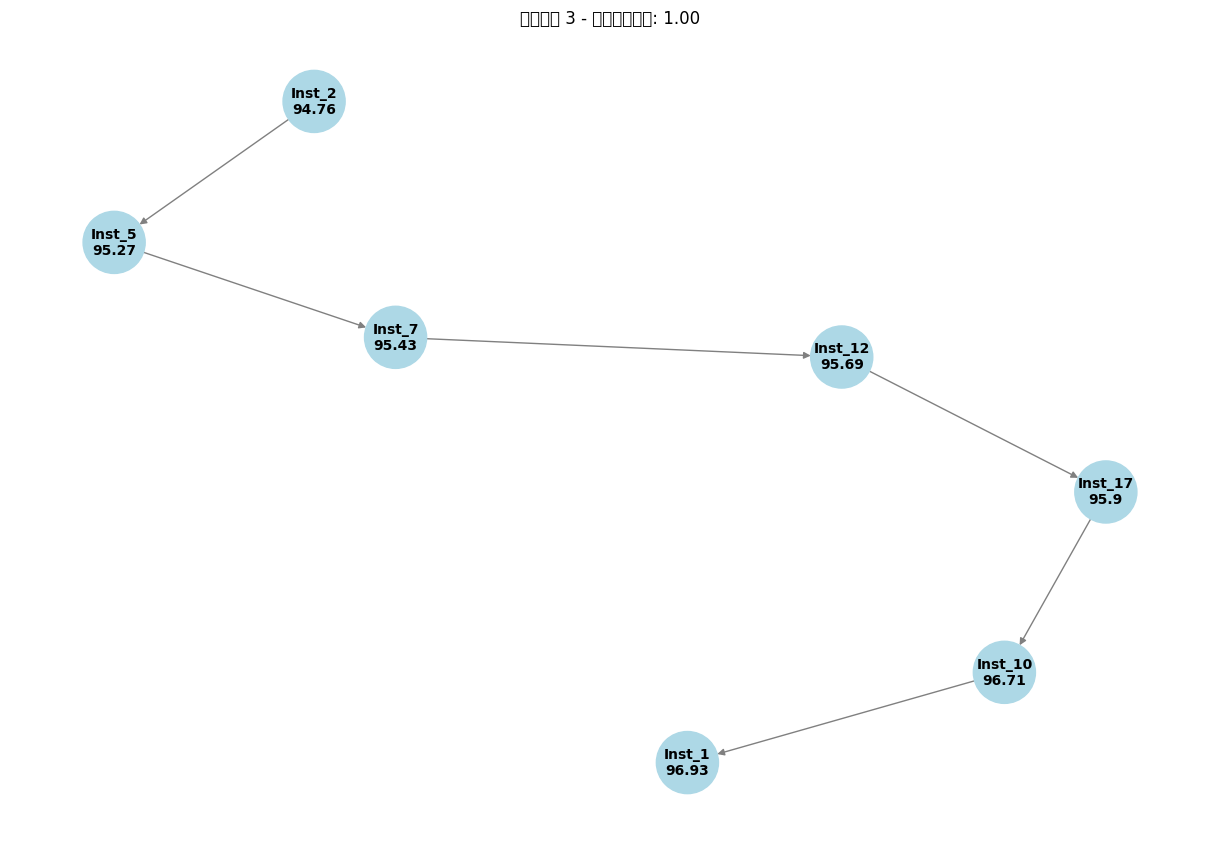

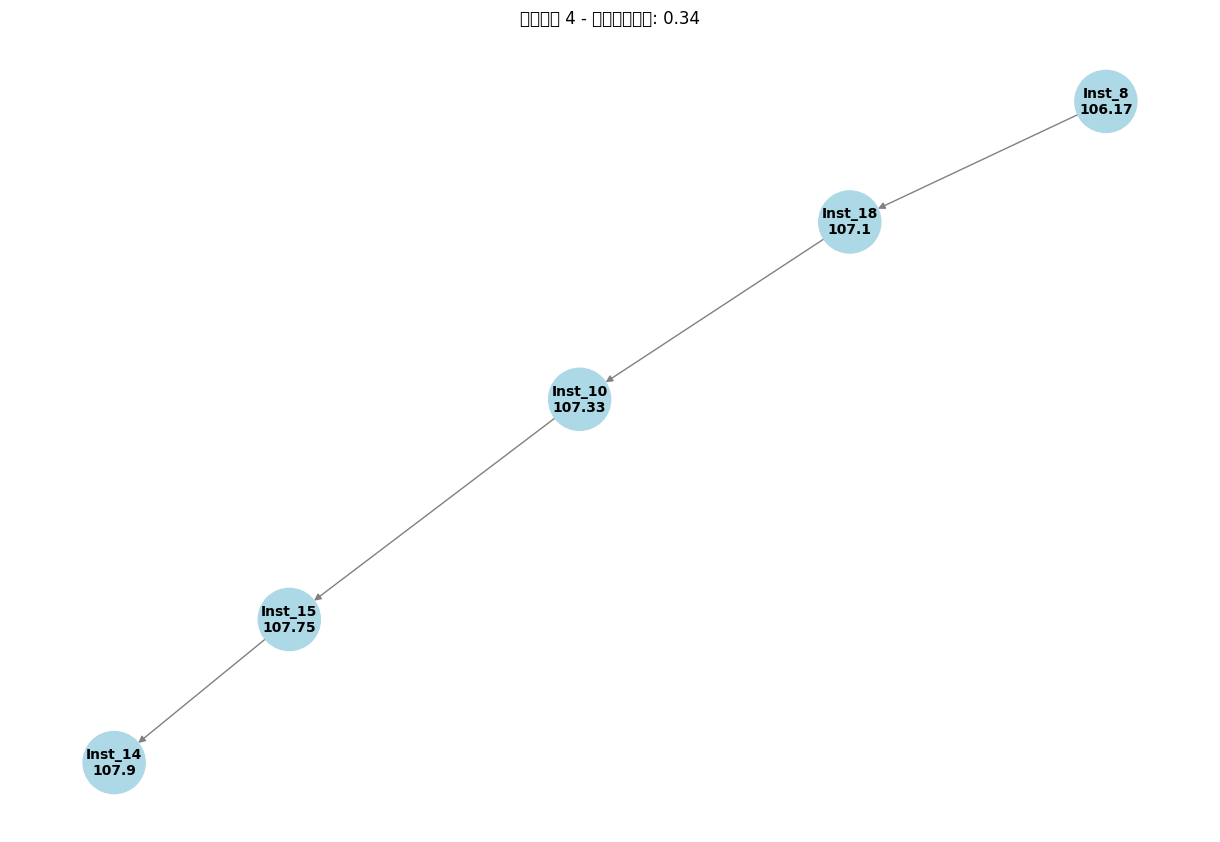

In [59]:
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import norm

# 生成模拟数据函数
def generate_synthetic_data(num_chains, max_chain_length, num_institutions):
    institutions = [f'Inst_{i}' for i in range(num_institutions)]
    data = []
    base_date = datetime(2024, 6, 1)

    for chain_id in range(num_chains):
        chain_length = random.randint(5, max_chain_length)
        prev_node_id = None
        base_price = round(random.uniform(90, 110), 2)  # 初始价格在90到110之间
        abnormal_institution = random.choice(institutions)
        abnormal_occurred = False

        for node_id in range(chain_length):
            institution = random.choice(institutions)
            if institution == abnormal_institution:
                if not abnormal_occurred and random.random() < 0.5:
                    price = round(base_price * (1 + random.uniform(0.02, 0.05)), 2)
                    abnormal_occurred = True
                else:
                    price = round(base_price * (1 + random.uniform(0, 0.01)), 2)
            else:
                price = round(base_price * (1 + random.uniform(0, 0.01)), 2)
            
            time = base_date + timedelta(days=node_id)
            data.append({
                "chain_id": chain_id,
                "node_id": node_id,
                "institution": institution,
                "price": price,
                "time": time.strftime("%Y-%m-%d"),
                "prev_node_id": prev_node_id
            })
            prev_node_id = node_id
            base_price = price  # 更新基准价格
    return data

# 生成模拟数据
random.seed(42)
synthetic_data = generate_synthetic_data(5, 10, 20)

# 数据预处理
prices = [t["price"] for t in synthetic_data]
mean_price = np.mean(prices)
std_price = np.std(prices)

# 异常概率计算
for t in synthetic_data:
    t["anomaly_prob"] = 1 - norm.cdf(t["price"], mean_price, std_price)

# 累计异常概率计算
def cumulative_anomaly_prob(chain):
    total_prob = 1
    for t in chain:
        total_prob *= (1 - t["anomaly_prob"])
    return 1 - total_prob

# 检测异常
def detect_anomalies(chain, price_threshold):
    institution_counts = {}
    anomalies = []

    for t in chain:
        institution = t["institution"]
        if institution not in institution_counts:
            institution_counts[institution] = []
        institution_counts[institution].append(t)

    for institution, trans in institution_counts.items():
        if len(trans) > 1:
            prices = [t["price"] for t in trans]
            max_diff = max(prices) - min(prices)
            if max_diff > price_threshold:
                anomalies.append((institution, max_diff))

    return anomalies

# 处理每条链路
chain_ids = set(t["chain_id"] for t in synthetic_data)
results = []

for chain_id in chain_ids:
    chain = [t for t in synthetic_data if t["chain_id"] == chain_id]
    cumulative_prob = cumulative_anomaly_prob(chain)
    anomalies = detect_anomalies(chain, price_threshold=2)  # 跳动2%即视为异常
    results.append({
        "chain_id": chain_id,
        "cumulative_prob": cumulative_prob,
        "anomalies": anomalies,
        "chain": chain
    })

# 可视化函数
def visualize_chain(chain, chain_id, anomalies):
    G = nx.DiGraph()

    for t in chain:
        G.add_node(t["node_id"], institution=t["institution"], price=t["price"], time=t["time"])
        if t["prev_node_id"] is not None:
            G.add_edge(t["prev_node_id"], t["node_id"])

    pos = nx.spring_layout(G)
    labels = {node: f'{data["institution"]}\n{data["price"]}' for node, data in G.nodes(data=True)}
    node_colors = ['red' if any(a[0] == data["institution"] for a in anomalies) else 'lightblue' for node, data in G.nodes(data=True)]

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_colors, node_size=2000, font_size=10, font_color='black', font_weight='bold', edge_color='gray')
    plt.title(f'交易链路 {chain_id} - 累计异常概率: {cumulative_anomaly_prob(chain):.2f}')
    plt.show()

# 可视化每条链路
for result in results:
    visualize_chain(result["chain"], result["chain_id"], result["anomalies"])


In [60]:
import json

# 生成模拟数据函数 (与之前的相同)
def generate_synthetic_data(num_chains, max_chain_length, num_institutions):
    institutions = [f'Inst_{i}' for i in range(num_institutions)]
    data = []
    base_date = datetime(2024, 6, 1)

    for chain_id in range(num_chains):
        chain_length = random.randint(5, max_chain_length)
        prev_node_id = None
        base_price = round(random.uniform(90, 110), 2)  # 初始价格在90到110之间
        abnormal_institution = random.choice(institutions)
        abnormal_occurred = False

        for node_id in range(chain_length):
            institution = random.choice(institutions)
            if institution == abnormal_institution:
                if not abnormal_occurred and random.random() < 0.5:
                    price = round(base_price * (1 + random.uniform(0.02, 0.05)), 2)
                    abnormal_occurred = True
                else:
                    price = round(base_price * (1 + random.uniform(0, 0.01)), 2)
            else:
                price = round(base_price * (1 + random.uniform(0, 0.01)), 2)
            
            time = base_date + timedelta(days=node_id)
            data.append({
                "chain_id": chain_id,
                "node_id": node_id,
                "institution": institution,
                "price": price,
                "time": time.strftime("%Y-%m-%d"),
                "prev_node_id": prev_node_id
            })
            prev_node_id = node_id
            base_price = price  # 更新基准价格
    return data

# 生成模拟数据
random.seed(42)
synthetic_data = generate_synthetic_data(12, 5, 2000)

# 构建力导向图的节点和边数据
nodes = []
links = []

# 添加节点
for t in synthetic_data:
    nodes.append({
        "id": t["node_id"],  # 节点ID
        "institution": t["institution"],  # 机构名称
        "price": t["price"],  # 价格
        "time": t["time"]  # 时间
    })

# 添加边
for t in synthetic_data:
    if t["prev_node_id"] is not None:
        links.append({
            "source": t["prev_node_id"],  # 边的起点
            "target": t["node_id"]  # 边的终点
        })

# 将节点和边组合成力导向图的数据结构
force_directed_data = {
    "nodes": nodes,
    "links": links
}

# 将数据保存为JSON文件
with open('force_directed_data.json', 'w') as f:
    json.dump(force_directed_data, f, indent=2)

print("力导向图数据已保存到 force_directed_data.json 文件中。")


力导向图数据已保存到 force_directed_data.json 文件中。


In [61]:
import json
import random
from datetime import datetime, timedelta

# 生成模拟数据函数
def generate_synthetic_data(num_chains, max_chain_length, num_institutions):
    institutions = [f'Inst_{i}' for i in range(num_institutions)]
    data = []
    base_date = datetime(2024, 6, 1)

    for chain_id in range(num_chains):
        chain_length = random.randint(5, max_chain_length)
        prev_node_name = None  # 使用节点名称
        base_price = round(random.uniform(90, 110), 2)  # 初始价格在90到110之间
        abnormal_institution = random.choice(institutions)
        abnormal_occurred = False

        for node_id in range(chain_length):
            institution = random.choice(institutions)
            if institution == abnormal_institution:
                if not abnormal_occurred and random.random() < 0.5:
                    price = round(base_price * (1 + random.uniform(0.02, 0.05)), 2)
                    abnormal_occurred = True
                else:
                    price = round(base_price * (1 + random.uniform(0, 0.01)), 2)
            else:
                price = round(base_price * (1 + random.uniform(0, 0.01)), 2)
            
            time = base_date + timedelta(days=node_id)
            data.append({
                "chain_id": chain_id,
                "node_name": institution,  # 使用机构名称作为节点名称
                "price": price,
                "time": time.strftime("%Y-%m-%d"),
                "prev_node_name": prev_node_name,  # 使用前一个节点的名称
                "is_abnormal": abnormal_occurred  # 标记异常节点
            })
            prev_node_name = institution  # 更新前一个节点名称
            base_price = price  # 更新基准价格
    return data

# 生成模拟数据
random.seed(42)
synthetic_data = generate_synthetic_data(12, 13, 2000)

# 构建力导向图的节点和边数据
nodes = []
links = []

# 添加节点
for t in synthetic_data:
    nodes.append({
        "id": t["node_name"],  # 使用节点名称作为节点ID
        "institution": t["node_name"],  # 机构名称
        "price": t["price"],  # 价格
        "time": t["time"],
        "isAbnormal": t["is_abnormal"]  # 标记是否异常节点
    })

# 添加边
for t in synthetic_data:
    if t["prev_node_name"] is not None:
        links.append({
            "source": t["prev_node_name"],  # 边的起点使用前一个节点的名称
            "target": t["node_name"]  # 边的终点使用当前节点的名称
        })

# 将节点和边组合成力导向图的数据结构
force_directed_data = {
    "nodes": nodes,
    "links": links
}

# 将数据保存为JSON文件
with open('force_directed_data.json', 'w') as f:
    json.dump(force_directed_data, f, indent=2)

print("力导向图数据已保存到 force_directed_data.json 文件中。")


力导向图数据已保存到 force_directed_data.json 文件中。


In [72]:
import json
import random
from datetime import datetime, timedelta

# 生成模拟数据函数
def generate_synthetic_data(num_chains, max_chain_length, num_institutions):
    institutions = [f'Inst_{i}' for i in range(num_institutions)]
    data = []
    base_date = datetime(2024, 6, 1)

    for chain_id in range(num_chains):
        chain_length = random.randint(5, max_chain_length)
        prev_node_name = None  # 使用节点名称
        base_price = round(random.uniform(90, 110), 2)  # 初始价格在90到110之间
        abnormal_occurred = False

        for node_id in range(chain_length):
            institution = random.choice(institutions)

            if not abnormal_occurred and random.random() < 0.2:
                price = round(base_price * (1 + random.uniform(0.02, 0.10)), 2)
                abnormal_occurred = True
            else:
                price = round(base_price * (1 + random.uniform(0, 0.01)), 2)

            time = base_date + timedelta(days=node_id)
            data.append({
                "chain_id": chain_id,
                "node_name": institution,  # 使用机构名称作为节点名称
                "price": price,
                "time": time.strftime("%Y-%m-%d"),
                "prev_node_name": prev_node_name,  # 使用前一个节点的名称
                "is_abnormal": abnormal_occurred  # 标记异常节点
            })
            abnormal_occurred = False
            prev_node_name = institution  # 更新前一个节点名称
            base_price = price  # 更新基准价格
    return data

# 生成模拟数据
random.seed(42)
synthetic_data = generate_synthetic_data(7, 10, 100)

# 构建力导向图的节点和边数据
nodes = []
links = []

# 添加节点
for t in synthetic_data:
    nodes.append({
        "id": t["node_name"],  # 使用节点名称作为节点ID
        "institution": t["node_name"],  # 机构名称
        "price": t["price"],  # 价格
        "time": t["time"],
        "isAbnormal": t["is_abnormal"]  # 标记是否异常节点
    })

# 添加边
for t in synthetic_data:
    if t["prev_node_name"] is not None:
        links.append({
            "source": t["prev_node_name"],  # 边的起点使用前一个节点的名称
            "target": t["node_name"],  # 边的终点使用当前节点的名称
            "isAbnormal": t["is_abnormal"]  # 边是否连接到异常节点
        })

# 将节点和边组合成力导向图的数据结构
force_directed_data = {
    "nodes": nodes,
    "links": links
}

# 将数据保存为JSON文件
with open('force_directed_data.json', 'w') as f:
    json.dump(force_directed_data, f, indent=2)
